In [1]:
import wittgenstein as rule
import torch
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from datasets.dataset import transform_dataset, kfold_dataset, predefined_dataset
from R2Ntab import R2Ntab
from rulelist import RuleList
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
#rom Orange.classification.rules import FURIA
from ConsistentLocalRules import *

#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
import sys
sys.executable

'/home/mike/miniconda3/envs/master/bin/python'

In [2]:
rule_learners = ['ripper', 'cart', 'c4.5', 'classy']
def run_learner(rule_learner, dataset):
    accuracies, sparsities = [], []
    if rule_learner == 'r2ntab':
        model = R2Ntab(train_set[:][0].size(1), 50, 1)
        if dataset == 'adult':
            train(model, train_set, test_set=test_set, device='cpu', lr_rules=1e-2, lr_cancel=1e-2, 
                    epochs=1000, batch_size=400, and_lam=1e-2, or_lam=1e-5, cancel_lam=1e-4, num_alter=500)
        elif dataset == 'heloc':
            train(model, train_set, test_set=test_set, device='cpu', lr_rules=1e-2, lr_cancel=1e-2, 
                    epochs=3000, batch_size=400, and_lam=1e-2, or_lam=1e-5, cancel_lam=1e-3, num_alter=500)
        else:
            train(model, train_set, test_set=test_set, device='cpu', lr_rules=1e-2, lr_cancel=1e-2, 
                    epochs=2000, batch_size=400, and_lam=1e-2, or_lam=1e-5, cancel_lam=1e-5, num_alter=500)
        acc = (model.predict(np.array(X_test)) == Y_test).mean()
        sparsity = sum(map(len, model.get_rules(X_headers)))
    elif rule_learner == 'ripper':
        for max_conditions in [20, 40, 60, 80, 100]
            model = rule.RIPPER(max_total_conds=max_conditions)
            model.fit(RX_train, Y_train)
            accuracies.append(model.score(RX_test, Y_test))
            sparsities.append(sum(len(rule) for rule in model.ruleset_))
    elif rule_learner == 'cart':
        for max_depth in [1, 2, 3, 4, 5]:
            model = DecisionTreeClassifier(max_depth=max_depth)
            model.fit(X_train, Y_train)
            accuracies.append(model.score(X_test, Y_test))
            sparsities.append(export_text(model, feature_names=X_train.columns.tolist()).count('('))
    elif rule_learner == 'c4.5':
        for max_depth in [1, 2, 3, 4, 5]:
            model = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
            model.fit(X_train, Y_train)
            accuracies.append(model.score(X_test, Y_test))
            sparsities.append(export_text(model, feature_names=X_train.columns.tolist()).count('('))
    elif rule_learner == 'classy':
        for max_depth in [20, 40, 60, 80, 100]:
            model = RuleList(task='prediction', target_model='categorical', max_depth=max_depth)
            rules = model.fit(X_train, Y_train)
            Y_pred = model.predict(X_test)
            accuracies.append(accuracy_score(Y_test, Y_pred))
            rules = str(rules)
            n_rules = rules.count("If") + rules.count("ELSE IF")
            sparsities.append(rules.count("AND") + n_rules)
        
    return accuracies, sparsities

In [ ]:
runs = 10
accuracies = {}
sparsities = {}
for learner in rule_learners:
    accuracies[learner] = []
    sparsities[learner] = []

dataset_names = ['adult', 'heloc', 'house', 'magic']
for dataset in dataset_names:
    X, Y, X_headers, Y_headers = transform_dataset(dataset, method='onehot-compare', negations=False, labels='binary')
    datasets = kfold_dataset(X, Y, shuffle=1)
    X_train, X_test, Y_train, Y_test = datasets[0]
    train_set = torch.utils.data.TensorDataset(torch.Tensor(X_train.to_numpy()), torch.Tensor(Y_train))
    test_set = torch.utils.data.TensorDataset(torch.Tensor(X_test.to_numpy()), torch.Tensor(Y_test))

    RX_train = pd.DataFrame(X_train)
    RX_train = RX_train.sort_index(axis=1)
    RX_test = pd.DataFrame(X_test)
    RX_test = RX_test.sort_index(axis=1)
    
    for run in range(runs):
        print(f'run {run+1}') 
        for learner in rule_learners:
            acc, sparsity = run_learner(learner, dataset)
            
            accuracies[learner].append(acc)
            sparsities[learner].append(sparsity)

run 1


2023-07-31 14:54:15.803760: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 14:54:15.842748: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 14:54:15.843274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 14:54:16.427963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Epoch:   1%|          | 10/1000 [00:03<05:54,  2.80it/s, rules cancelled=0, loss

In [38]:
for learner in rule_learners:
    print(learner, np.mean(accuracies[learner]), np.std(accuracies[learner]), np.mean(sparsities[learner]), np.std(sparsities[learner]))

ripper 0.8053543998244459 0.0 234.0 0.0
cart 0.8240070221637041 0.0 1792.0 0.0
c4.5 0.82642089093702 0.0 1690.0 0.0


In [8]:
import json

with open('exp4accs.json', 'w') as file:
    json.dump(accuracies, file)

with open('exp4spars.json', 'w') as file:
    json.dump(sparsities, file)max_depth=1

In [9]:
print(accuracies)
print(sparsities)heloc

{'r2ntab': [0.8044090833747721, 0.8173379744737278, 0.8314271506713078, 0.8322559257417537, 0.8196585446709763, 0.8191612796287088, 0.8208188297696005, 0.831592905685397, 0.8140228741919443, 0.8352395159953588, 0.7174952198852772, 0.6964627151051626, 0.6945506692160612, 0.7146271510516252, 0.6902485659655831, 0.7122370936902486, 0.6998087954110899, 0.6988527724665392, 0.7179732313575525, 0.7050669216061185, 0.8433179723502304, 0.826201448321264, 0.8246653500109721, 0.8389291200351108, 0.836515251261795, 0.8389291200351108, 0.8283958744788238, 0.8347597103357473, 0.8305903006363836, 0.8235681369321922, 0.8228180862250263, 0.8454258675078864, 0.8309674027339643, 0.833596214511041, 0.823080967402734, 0.8338590956887487, 0.8286014721345951, 0.8046792849631966, 0.8251840168243953, 0.8299158780231335], 'ripper': [0.827780540361346, 0.8310956406431295, 0.8286093154317918, 0.8264545002486325, 0.8307641306149511, 0.8276147853472567, 0.8267860102768109, 0.8267860102768109, 0.8302668655726836, 0.

In [4]:
X, Y, X_headers, Y_headers = transform_dataset('heloc', method='onehot-compare', negations=False, labels='binary')
datasets = kfold_dataset(X, Y, shuffle=1)
X_train, X_test, Y_train, Y_test = datasets[0]
train_set = torch.utils.data.TensorDataset(torch.Tensor(X_train.to_numpy()), torch.Tensor(Y_train))
test_set = torch.utils.data.TensorDataset(torch.Tensor(X_test.to_numpy()), torch.Tensor(Y_test))

In [ ]:
model = RuleList(task = 'prediction', target_model = 'categorical', max_depth=60)
attribute_names = vars(model)  # or obj.__dict__
for attribute_name in attribute_names:
    print(attribute_name)
rules = model.fit(X_train, Y_train)

target_model
alpha_gain
max_depth
beam_width
min_support
n_cutpoints
discretization
task
number_rules
max_rules
_rulelist
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15


In [ ]:
Y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

In [ ]:
rules = str(rules)
n_rules = rules.count("If") + rules.count("ELSE IF")
n_conditions = rules.count("AND") + n_rules
print(n_rules)
print(n_conditions)
print(rules)

In [2]:
X_T, Y_T, _, _ = predefined_dataset('heloc')
X_T = X_T.fillna(0)

le = LabelEncoder()
Y_T = le.fit_transform(Y_T).astype(int)

Y_T = pd.Series(Y_T, dtype=object)

explainer = ConsistentRulesExplainer(X_T, Y_T)

In [ ]:
df_explanations = explainer.explain(X_T, Y_T, objective='SPARSITY', n_explanations=10, max_features=100)
#print(df_explanations.loc[:,"Rule"].values)

  x1 x2  y
0  0  0  1
1  0  1  0
2  1  0  0
3  1  1  0


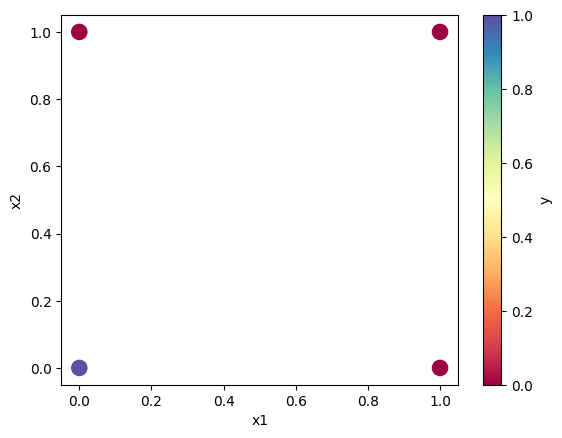

In [96]:
X,Y_global,df = toy_binary_dataset(plot=True, print_table=True)

In [97]:
explainer = ConsistentRulesExplainer(X, Y_global)   

In [98]:
df_explanations = explainer.explain(X, Y_global, objective='SPARSITY', n_explanations=10, max_features=9999)

In [105]:
print(type(X))
print("hoi")
print(type(Y_global))
print(X)
print(Y_global)

<class 'pandas.core.frame.DataFrame'>
hoi
<class 'pandas.core.series.Series'>
  x1 x2
0  0  0
1  0  1
2  1  0
3  1  1
0    1
1    0
2    0
3    0
Name: y, dtype: object


In [6]:
df_explanations

,#Observation,#Explanation,Rule,Prediction,Support,#Features,Runtime,Algorithm
0,0,0,"69.00<=PercentTradesWBalance<=69.00, ExternalR...",0,7,2,10.0,ContMinSetCover
1,0,1,"83.00<=PercentTradesNeverDelq<=83.00, MaxDelq2...",0,22,2,10.0,ContMinSetCover
2,0,2,"NumTrades60Ever2DerogPubRec>=3.00, 33.00<=NetF...",0,7,2,10.0,ContMinSetCover


In [8]:
X, Y, X_headers, Y_headers = transform_dataset('heloc', method='onehot-compare', negations=False, labels='binary')
datasets = kfold_dataset(X, Y, shuffle=1)
X_train, X_test, Y_train, Y_test = datasets[0]
train_set = torch.utils.data.TensorDataset(torch.Tensor(X_train.to_numpy()), torch.Tensor(Y_train))
test_set = torch.utils.data.TensorDataset(torch.Tensor(X_test.to_numpy()), torch.Tensor(Y_test))

In [20]:
RX_train = pd.DataFrame(X_train)
RX_train = RX_train.sort_index(axis=1)
RX_test = pd.DataFrame(X_test)
RX_test = RX_test.sort_index(axis=1)

model = rule.RIPPER(max_total_conds=100)
model.fit(RX_train, Y_train)
acc = model.score(RX_test, Y_test)
sparsity = sum(len(rule) for rule in model.ruleset_)

In [21]:
print(acc)
print(sparsity)
print(model.ruleset_)

0.6878585086042065
64
[["(ExternalRiskEstimate^<=^74.0)=0"^"(ExternalRiskEstimate^<=^81.0)=0"^"(MSinceMostRecentInqexcl7days^<=^2.4777188328912465)=0"] V ["(ExternalRiskEstimate^<=^72.06044011763512)=0"^"(ExternalRiskEstimate^<=^78.0)=0"^"(MSinceMostRecentInqexcl7days^<=^0.0)=0"^"(NumSatisfactoryTrades^<=^12.0)=0"^"(AverageMInFile^<=^78.0)=0"] V ["(ExternalRiskEstimate^<=^72.06044011763512)=0"^"(ExternalRiskEstimate^<=^78.0)=0"^"(AverageMInFile^<=^63.0)=0"^"(NumBank2NatlTradesWHighUtilization^<=^0.0)=1"^"(PercentTradesWBalance^<=^71.0)=1"^"(NumSatisfactoryTrades^<=^12.0)=0"^"(MaxDelqEver^<=^7.0)=0"^"(MSinceOldestTradeOpen^<=^173.0)=1"^"(MSinceMostRecentTradeOpen^<=^9.588491540877317)=1"] V ["(ExternalRiskEstimate^<=^72.06044011763512)=0"^"(AverageMInFile^<=^63.0)=0"^"(NetFractionRevolvingBurden^<=^33.0)=1"^"(MaxDelq2PublicRecLast12M^<=^6.0)=0"^"(NetFractionRevolvingBurden^<=^14.0)=1"^"(NumTotalTrades^<=^8.0)=0"] V ["(ExternalRiskEstimate^<=^69.0)=0"^"(ExternalRiskEstimate^<=^74.0)=0"^"

In [37]:
model = DecisionTreeClassifier(max_depth=1)
model.fit(X_train, Y_train)
acc = model.score(X_test, Y_test)
sparsity = export_text(model, feature_names=X_train.columns.tolist()).count('(')

In [38]:
print(acc)
print(sparsity)

0.7031548757170172
2


In [39]:
print(export_text(model, feature_names=X_train.columns.tolist()))

|--- ('ExternalRiskEstimate', '<=', 74.0) <= 0.50
|   |--- class: 1
|--- ('ExternalRiskEstimate', '<=', 74.0) >  0.50
|   |--- class: 0



In [7]:
cls = Classifier(name='weka.classifiers.rules.FURIA')

In [14]:
print(dir(cls))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_ckargs_str', '_model_data', 'ckargs', 'last_training_stderr', 'last_training_stdout', 'load', 'load_raw', 'name', 'predict', 'save', 'schema', 'test', 'train', 'training_correlation_coefficient', 'training_mean_absolute_error']


In [11]:
cls.train(X_train, Y_train)

AssertionError: 